In [1]:
from input import *

locals().update(params_value_kragarm)

# Einführungsbeispiel

Das Einführungsbeispiel verfolgt das Ziel das Modellverhalten zu plausibilisieren. Die Eingabe der nicht-linearen Parameter in der Statiksoftware liegt im Vordergrund.

Es werden die Verformungen des fiktiven Beispiels von Hand mittels der Arbeitsgleichung, sowie numerisch mit der Stabstatik-Software ermittelt. Das statische System ist in @fig-kragarm-feder aufgezeigt. Das Beispiel ist mit einer Drehfeder versehen, welche eine nicht-lineare Federcharakteristik aufweist. Es werden zwei Laststufen betrachtet. Diese sind entsprechend gewählt, dass das nicht-lineare Verhalten der Drehfeder zu tragen kommt.

![Statisches System des Kragarms](../imgs/Kragarm_system_Feder.svg){#fig-kragarm-feder}



Die Parameter in der @tbl-parameters-kragarm dienen als Berechnungsgrundlagen. Beschrieben sind die Abmessungen und Materialeigenschaften, sowie die beiden Laststufen $F_1$ und $F_2$, wie auch die  Federsteifigkeiten $k_1$ und $k_2$.

In [2]:
#| label: tbl-parameters-kragarm
#| tbl-cap: "Berechnungsparameter des Kragarms"

dict_to_table(params_kragarm)

|  Parameter  | ​  |
|---|---|
| $E = \frac{10000 \text{N}}{\text{mm}^{2}}$ | $F_{1} = - 10000 \text{N}$ |
| $F_{2} = - 21500 \text{N}$ | $b = 200 \text{mm}$ |
| $h = 400 \text{mm}$ | $k_{1} = \frac{100000 \text{N}}{\text{m}}$ |
| $k_{2} = \frac{10000 \text{N}}{\text{m}}$ | $l_{Kragarm} = 5 \text{m}$ |
| $z = 400 \text{mm}$ | ​  |


Der Rechteckquerschnitt ist in @fig-qs-kragarm aufgezeigt, dieser gilt für den gesamten Kragarm.

![Fiktiver Querschnitt des Kragarms mit durchwegs linear-elastischem Materialverhalten](../imgs/Kragarm_querschnitt.svg){#fig-qs-kragarm}

Die Entsprechende Federcharakteristik ist in @fig-springcharacteristic zu sehen. Das Bilineare Verhalten gilt für positive und negative Biegemomente um die $Y$-Achse.

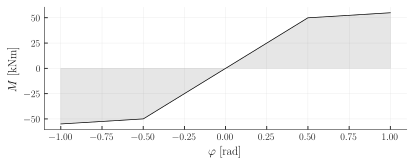

In [3]:
#| label: fig-springcharacteristic
#| fig-cap: "Charakteristik der Drehfeder"


def M_phi_spring(phi: np.array, k_phi1, k_phi2):
    phi_1, phi_2, phi_3, phi_4 = np.array_split(phi, 4)
    M_phi_1 = phi_3 * k_phi1
    M_phi_2 = M_phi_1[-1] + phi_3 * k_phi2
    M_phi_3 = np.flip(-M_phi_1)
    M_phi_4 = np.flip(-M_phi_2)

    M_phi = np.concatenate((M_phi_4, M_phi_3, M_phi_1, M_phi_2))
    return M_phi


# Arrays
Phi_spring_array = np.linspace(-1, 1, 1000)
M_phi_array = M_phi_spring(Phi_spring_array, k_1, k_2)


plt.plot(Phi_spring_array, M_phi_array / 10**3, color="black")
plt.fill_between(Phi_spring_array, M_phi_array / 10**3, color="black", alpha=0.1)

plt.xlabel("$\\varphi$ [rad]")
plt.ylabel("$M$ [kNm]")
plt.show()

## Biegeverformung

Zunächst werden die Biegeverformungen mittels der Differentialgleichung für reine Biegeträger ermittelt. Dabei wird die Drehfeder vernachlässigt. Das statische System, gezeigt in @fig-kragarm-sys führt zu den Zustandslinien der Schnittgrössen in der @fig-skkragarmreal.


![Statisches System des Kragarms](../imgs/Kragarm_System.svg){#fig-kragarm-sys}

In [4]:
# GEOMETRY System
x_array = np.linspace(0, to_float(l_Kragarm), 500)
q_array = np.zeros(len(x_array))
I = h**3 * b / 12


def V_x(c, q_x, x):
    q_integrated = integrate.cumulative_trapezoid(q_x, x, initial=0)
    return -q_integrated + c[0]


def M_x(c, q_x, x):
    V_x_calc = V_x(c, q_x, x)
    V_integrated = integrate.cumulative_trapezoid(V_x_calc, x, initial=0)
    return V_integrated + c[1]


def Phi_x(c, q_x, x, E, I):
    M_x_calc = M_x(c, q_x, x)
    M_integrated = integrate.cumulative_trapezoid(M_x_calc, x, initial=0)
    return 1 / (E * I) * M_integrated + c[2]


def w_x(c, q_x, x, E, I):
    Phi_x_calc = Phi_x(c, q_x, x, E, I)
    Phi_integrated = -integrate.cumulative_trapezoid(Phi_x_calc, x, initial=0)
    return Phi_integrated + c[3]


# Define the equations to solve


def calc_internal_forces(F: float):
    def initial_conditions(c):
        return [
            V_x(c, q_array, x_array)[0] + F,  # Shear force at the start is F
            M_x(c, q_array, x_array)[-1],  # Bending moment at the end is 0
            Phi_x(c, q_array, x_array, E, I)[0],  # Angle or rotation at the start is 0
            w_x(c, q_array, x_array, E, I)[0],
        ]  # Displacement at the start is 0

    # Solve for the integration constants
    integration_constants = fsolve(initial_conditions, [1, 1, 1, 1])

    V_x_array = V_x(integration_constants, q_array, x_array)
    M_x_array = M_x(integration_constants, q_array, x_array)
    Phi_x_array = Phi_x(integration_constants, q_array, x_array, E, I)
    w_x_array = w_x(integration_constants, q_array, x_array, E, I)

    return V_x_array, M_x_array, Phi_x_array, w_x_array


internal_forces_F1 = calc_internal_forces(F1)
internal_forces_F2 = calc_internal_forces(F2)

In [5]:
plot_counter_inner_forces = 1


def plot_inner_forces(
    V: np.array,
    M: np.array,
    Phi: np.array,
    w: np.array,
    x: np.array,
    kinematic=True,
    colors: list = ["green", "orange", "red", "blue"],
):
    global plot_counter_inner_forces

    fig, axs = plt.subplots(2, 2, figsize=(6, 4))

    # Plot V_x_array
    axs[0, 0].plot(x, V / 1000, color=colors[0], alpha=0.5)
    axs[0, 0].fill_between(x, V / 1000, color=colors[0], alpha=0.1)
    axs[0, 0].plot(x, x * 0, color="black")
    axs[0, 0].set_xlabel("$x$ [m]")
    axs[0, 0].set_ylabel("$V$ [kN]")

    # Plot M_x_array
    axs[0, 1].plot(x, M / 10**3, color=colors[1], alpha=0.5)
    axs[0, 1].fill_between(x, M / 10**3, color=colors[1], alpha=0.1)
    axs[0, 1].plot(x, x * 0, color="black")
    axs[0, 1].invert_yaxis()  # Invert the y-axis

    axs[0, 1].set_xlabel("$x$ [m]")
    axs[0, 1].set_ylabel("$M$ [kNm]")

    # Plot Phi_x_array
    axs[1, 0].plot(x, Phi, color=colors[2], alpha=0.5)
    axs[1, 0].fill_between(x, Phi, color=colors[2], alpha=0.1)
    axs[1, 0].plot(x, x * 0, color="black")
    axs[1, 0].set_xlabel("$x$ [m]")
    # axs[1, 0].set_ylim(0,1)
    axs[1, 0].set_ylabel("$\\varphi$ [-]")

    # Plot w_x_array
    axs[1, 1].plot(x, w * 1000, color=colors[3], alpha=0.5)
    axs[1, 1].fill_between(x, w * 1000, color=colors[3], alpha=0.1)
    axs[1, 1].plot(x, x * 0, color="black")
    axs[1, 1].invert_yaxis()  # Invert the y-axis
    axs[1, 1].set_xlabel("$x$ [m]")
    axs[1, 1].set_ylabel("$w$ [mm]")

    if kinematic == False:
        fig.delaxes(axs[1, 1])
        fig.delaxes(axs[1, 0])

    plt.tight_layout()
    plt.savefig(f"imgs/inner_forces_{plot_counter_inner_forces}.svg")
    plt.show()
    plot_counter_inner_forces += 1

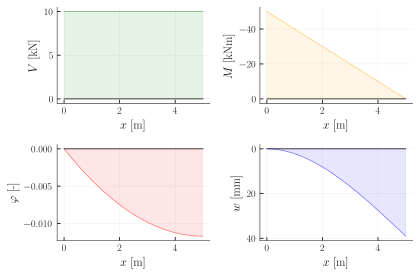

In [6]:
#| label: fig-skkragarmreal
#| fig-cap: "Schnittkräfte des Systems aus @fig-kragarm-sys für die Last $F_1$"

plot_inner_forces(*internal_forces_F1, x_array, kinematic=True)

Die maximale Verformung am Endpunkt des Kragarms beträgt:

In [7]:
w_max_hand = round(-F1 * l_Kragarm**3 / (3 * E * I), 5)
w_bending_F1 = round(internal_forces_F1[-1][-1], 5)

display_eq("w_1,Bending,F1", to_convert(w_bending_F1 * unit.meter, unit.mm))
assert w_max_hand == w_bending_F1, "Handcalculation shows differences"

w_1,Bending,F1 = 39.06⋅millimeter

Das analoge Vorgehen führt für die Laststufe $F_2$ zu den Zustandslinien der Schnittgrössen gemäss der  @fig-skkragarmreal_high.

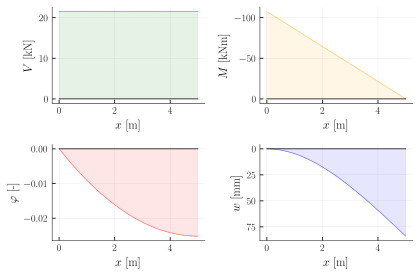

In [8]:
#| label: fig-skkragarmreal_high
#| fig-cap: "Schnittkräfte des Systems aus @fig-kragarm-sys für die Last $F2$"

plot_inner_forces(*internal_forces_F2, x_array)

Da ein durchwegs linear-elastisches Biegeverhalten vorausgesetzt wird, entspricht der Faktor der Erhöhung des Verformung dem Quotient der beiden Laststufen.

$$
\frac{w_{1,Bending,F2}}{w_{1,Bending,F1}} = \frac{F_2}{F_1}
$${#eq-quotient_biegeverformung}

Dabei entspricht die maximale Biegeverformung am Ende des Kragarms:

In [9]:
w_bending_F2 = round(internal_forces_F2[-1][-1], 5)


display_eq("w_1,Bending,F_2", to_convert(w_bending_F2 * unit.meter, unit.mm))

w_1,Bending,F_2 = 83.98⋅millimeter

## Verformung der Drehfeder

Zur Bestimmung der Verformung am Ende des Kragarms des Systems mit der Drehfeder wird die Arbeitsgleichung angewendet. Dazu wird an einem virtuellen System eine Einzellast eingeführt, an der Stelle an dem die Verformung bestimmt werden soll. Dargestellt ist dies in @fig-kragarm-sys-virtuell. 

![Statisches System des Kragarms im virtuellen Kräftezustand](../imgs/Kragarm_system_feder_virtuell.svg){#fig-kragarm-sys-virtuell}

Die entsprechenden Verläufe der Querkraft und des Biegemoments zeigt die @fig-sk-kragarm-virtuell für das virtuelle System.

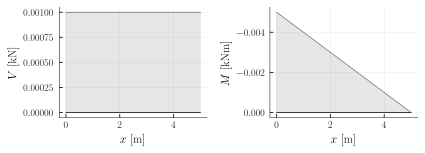

In [10]:
#| label: fig-sk-kragarm-virtuell
#| fig-cap: "Schnittkräfte des virtuellen Systems aus @fig-kragarm-sys-virtuell"

internal_forces_virtual = calc_internal_forces(-1.0)

plot_inner_forces(
    *internal_forces_virtual,
    x_array,
    kinematic=False,
    colors=["black", "black", "black", "black"]
)

Die Verformung der Drehfeder kann abschliessend mit der @eq-spring_rotation bestimmt werden. 

$$
w_{Spring} = \bar{M} \frac{M}{k_\varphi} = \bar{M} \varphi
$${#eq-spring_rotation}

Die Verdrehung lässt sich aus der Federcharakteristik mit dem Biegemoment an der Stelle der Drehfeder bestimmen. Die @fig-feder-force zeigt die Position der Laststufen im Diagramm. 

In [11]:
# Takes the corresponding phi for the middle M
phi_spring_F1 = np.interp(
    np.median(internal_forces_F1[1]), M_phi_array, Phi_spring_array
)
phi_spring_F2 = np.interp(
    np.median(internal_forces_F2[1]), M_phi_array, Phi_spring_array
)

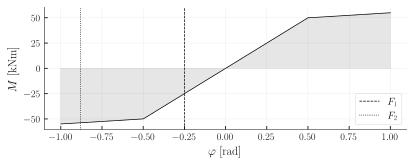

In [12]:
#| label: fig-feder-force
#| fig-cap: "Charakteristik der Drehfeder mit Bestimmung der Verdrehung anhand der Laststufen"


plt.plot(Phi_spring_array, M_phi_array / 10**3, color="black")
plt.fill_between(Phi_spring_array, M_phi_array / 10**3, color="black", alpha=0.1)

plt.axvline(x=phi_spring_F1, color="black", linestyle="--", label="$F_1$")
plt.axvline(x=phi_spring_F2, color="black", linestyle="dotted", label="$F_2$")


plt.xlabel("$\\varphi$ [rad]")
plt.ylabel("$M$ [kNm]")
plt.legend()
plt.savefig("imgs/spring_charact.svg")
plt.show()


Angewendet auf das System der @fig-kragarm-feder folgen für die beiden Laststufen die Deformationen der Drehfeder zu:

In [13]:
w_spring_F1 = np.median(internal_forces_virtual[1]) * phi_spring_F1
w_spring_F2 = np.median(internal_forces_virtual[1]) * phi_spring_F2


display_eq(
    "w_1,spring,F1", unit.convert_to(np.round(w_spring_F1, 4) * unit.meter, unit.mm)
)
display_eq(
    "w_1,spring,F2", unit.convert_to(np.round(w_spring_F2, 4) * unit.meter, unit.mm)
)

w_1,spring,F1 = 625.0⋅millimeter

w_1,spring,F2 = 2201.3⋅millimeter

Dazu gilt es den Anteil aus der Biegeverformung zu addieren. Die totale Verformung folgt zu:

In [14]:
w_tot_F1 = w_spring_F1 + w_bending_F1
w_tot_F2 = w_spring_F2 + w_bending_F2


display_eq('w_1,tot,F1', to_convert((w_tot_F1)*unit.m, unit.mm).evalf(4))
display_eq('w_1,tot,F2', to_convert((w_tot_F2)*unit.m, unit.mm).evalf(4))

w_1,tot,F1 = 664.1⋅millimeter

w_1,tot,F2 = 2285.0⋅millimeter

## Stabstatikmodell

Das statische System, gemäss @fig-kragarm-feder, wird mittels der Statiksoftware AxisVM X7 modelliert. Dazu wird die Drehfeder als Federelement modelliert und in der $YY$-Dimension mit der Federcharakteristik ergänzt. Die angeschlossenen Stäbe sind mit entsprechendem Querschnitt und der entsprechenden Biegesteifigkeit modelliert.

Die Deformationen in $Z$-Richtung sind in @fig-kragarm-drehfeder-10 und @fig-kragarm-drehfeder-215

![Verformungen in $z$ für $F_1$ aus AxisVM mit Drehfedermodell](../imgs/Kragarm_drehfeder_10.svg){#fig-kragarm-drehfeder-10}

Das Modell liefert für die erste Laststufe die Gesamtverformung von:

$$
w_{1,tot,F1} = 663.5 \text{mm}
$${#eq-w_tot_f1_modell}

![Verformungen in $z$ für $F_2$ aus AxisVM mit Drehfedermodell](../imgs/Kragarm_drehfeder_215.svg){#fig-kragarm-drehfeder-215}

So wie für die zweite Laststufe folgt die Gesamtverformung zu:


$$
w_{1,tot,F2} = 2265.1 \text{mm}
$${#eq-w_tot_f2_modell}


Das Modell liefert die annähernd gleichen Resultate wie die Handrechnung. Die Genauigkeit ist zufriedenstellend.

### Modellierungsalternative Wegfeder

Wie bereits in @sec-modellvorstellung aufgezeigt, lässt sich das Verhalten der Drehfeder mit einem Wegfederpaar abbilden. Dazu wird in einem ersten Schritt die Drehfedercharakteristik in eine Wegfedercharakteristik umgerechnet. Als Grundlage dient die Modellierung gemäss @fig-verdrehung_verformung. Die Abbildung zeigt die kinematische Relation eines reinen Biegeelements.

![Kinematische Relation eines reinen Biegeelements](../imgs/Skizze_Verdrehung_Verformung.svg){#fig-verdrehung_verformung}

Mittels der @eq-FfromM und @eq-ufromphi lässt sich so die Wegfedercharakteristik bestimmen. Der Abstand zwischen dem Wegfederpaar wird mit $z$ beschrieben.

$$
F = \frac{M}{z}
$${#eq-FfromM}

$$
u = \frac{\tan(\varphi) \cdot z}{2} \simeq \frac{\varphi \cdot z}{2}
$${#eq-ufromphi}

Durch die Berücksichtigung der trigonometrischen Funktion in @eq-ufromphi ist der Verlauf nicht exakt bilinear. Eine Approximation mit einem bilinearen Verlauf führt zu beträchtlichen Abweichungen unter der zweiten Laststufe $F_2$. Dies ist auf die geringe Neigung, bzw. $k_2$ der Drehfedercharakteristik im oberen Lastniveau zurückzuführen.

Die umgerechnete Wegfedercharakteristik ist in @fig-wegfeder-force aufgezeigt.

In [15]:
def F_u_spring(M: np.array, Phi: np.array, z: float):
    F = M / z
    u = np.tan(Phi) * z / 2

    return F, u


F_array, u_array = F_u_spring(M_phi_array, Phi_spring_array, z)

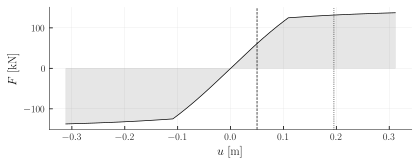

In [16]:
#| label: fig-wegfeder-force
#| fig-cap: "Charakteristik der Wegfeder"


# The deformations for the corresponding F
index_F1 = np.argmin(np.abs(F_array - 61.25 * 1000))
u_F1 = u_array[index_F1]

index_F2 = np.argmin(np.abs(F_array - 131.69 * 1000))
u_F2 = u_array[index_F2]

plt.axvline(x=u_F1, color="black", linestyle="--", label="$F_1$")
plt.axvline(x=u_F2, color="black", linestyle="dotted", label="$F_2$")


plt.plot(u_array, F_array / 10**3, color="black")
plt.fill_between(u_array, F_array / 10**3, color="black", alpha=0.1)
plt.xlabel("$u$ [m]")
plt.ylabel("$F$ [kN]")
plt.savefig("imgs/F_u.svg")
plt.show()

In [17]:
# Federgesetz wird zu einer Textdatei gespeichert um diese ins AxisVM zu implementieren

array_reduced = np.linspace(min(u_array),max(u_array),100)
F_array_reduce = np.interp(array_reduced, u_array, F_array)
u_array_reduce = np.interp(F_array_reduce, F_array, u_array)

# Save the array to a text file
np.savetxt('u_array.txt', u_array_reduce*1000)
np.savetxt('F_array.txt', F_array_reduce/1000)

Die Resultate mit dem Modell sind in der @fig-f1-wegfeder und @fig-f2-wegfeder gezeigt.

![Verformungen in $z$ für $F_1$ aus AxisVM mit Wegfedermodell](../imgs/Kragarm_wegfeder_10.svg){#fig-f1-wegfeder}

Die maximale Verformung in $Z$-Richtung ist für die Laststufe $1$:

$$
w_{1,tot,F1} = 655 \text{mm}
$${#eq-wtotf1-wegfeder}

Und für die Laststufe $2$:

$$
w_{1,tot,F2} = 2137.8 \text{mm}
$${#eq-wtotf2-wegfeder}


Diese sind mit den Resultaten in @eq-w_tot_f1_modell und @eq-w_tot_f2_modell zu vergleichen. Hier zeigt sich eine Abweichung. Diese lässt sich auf die numerisch approximierte Modellierung der Wegfederbeziehung zurückführen.


![Verformungen in $z$ für $F_2$ aus AxisVM mit Wegfedermodell](../imgs/Kragarm_wegfeder_215.svg){#fig-f2-wegfeder}

# Modellverifizierung

In diesem Kapitel werden die beiden Versuche aus der Vorarbeit @gitz_ansatze_2024 mit einem Drehfedermodell, gemäss dem Beschrieb in @sec-modellvorstellung, nachgerechnet. Dazu wird eine feine Stabunterteilung gewählt, um das Verformungsverhalten präzise abzubilden. Detaillierte Berechnungen und Versuchsbeschriebe, welche als Grundlagen für die Modellierung dienen, sind in @gitz_ansatze_2024 zu finden. Grundsätzlich gilt, dass für den Betonstahl Bilineare Spannungs-Dehnungs-Beziehungen hinterlegt sind und für den Beton ein elastisch-ideal-plastisches Gesetz mit Berücksichtigung der Zugfestigkeit.

## Dreipunktbiegeversuch

Der Dreipunktbiegeversuch ist der dritte Versuch der Serie A in der zweiten Versuchsanordnung aus @jager_versuche_2006, kurz betitelt mit A3V2. Dieser ist mit einer durchegehenden Längsbewehrung im Zugbereich bewehrt. Die Schubdübel sind nicht durchgängig verlegt. Dargestellt ist das Bewehrungslayout in der @fig-bewehrung_a3v2.

![Bewehrunslayout des Versuchs A3V2, Zeichnung entnommen aus @jager_versuche_2006](../imgs/bewehrung_a3v2.svg){#fig-bewehrung_a3v2}

Das statische System des Versuchs ist in @fig-system_a3v2 dargestellt. Das Eigengewicht wird vernachlässigt, da die Verformungsmessungen nach dem Einbau des Versuchs beginnen, bzw. erst bei Belastungsbeginn mit der Einzellast.


![Statisches System des Versuchs A3V2, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/System_anordnung_2.svg){#fig-system_a3v2}


Die @fig-qs_a3v2 zeigt den Querschnitt des Versuchs mit der entsprechenden Bewehrungsführung. 

![Querschnitt des Versuchs A3V2, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/QS_Versuch_A3.svg){#fig-qs_a3v2}


### Drehfedercharakteristik

Als erster Eingabeparamter in das Drehfedermodell dient die Momenten-Krümmungs-Beziehung. Für den Querschnitt ist die nicht-lineare Beziehung in der @fig-mchi_a3v2 gezeigt. Detaillierte Berechnungen sind in der Vorarbeit @gitz_ansatze_2024 zu finden.

In [18]:
# Read the text file using numpy
M_array = np.loadtxt("docs/M_A3V2.txt")
chi_array = np.loadtxt("docs/chi_A3V2.txt")

chi_zugversteifung_1_array = chi_array.copy()

chi_zugversteifung_1_array[2] = chi_array[2]-0.00131
chi_zugversteifung_1_array[3] = chi_array[3]-0.00131


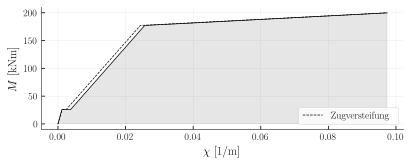

In [19]:
#| label: fig-mchi_a3v2
#| fig-cap: "Momenten-Krümmungs-Beziehung des Dreipunktbiegeversuchs, übernommen aus @gitz_ansatze_2024"


chi_interpolated = np.linspace(0, max(chi_array), 1000)
# Linear interpolation in M_array
M_interpolated = np.interp(chi_interpolated, chi_array, M_array)
M_1_interpolated = np.interp(chi_interpolated, chi_zugversteifung_1_array, M_array)
# Plot the interpolated data
plt.plot(chi_interpolated, M_1_interpolated / 10**3, color="black", linestyle='dashed', label='Zugversteifung')

plt.plot(chi_interpolated, M_interpolated / 10**3, color="black")
plt.fill_between(chi_interpolated, M_interpolated / 10**3, color="black", alpha=0.1)
plt.xlabel("$\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.legend()
plt.savefig("imgs/M_chi_A3V2.svg")
plt.show()

In [20]:
l_element = 0.01 * unit.meter

#### Schiebung

Als Grundlage zur Modellierung der Schubverformungen dient das Spannungsfeld-Modell in @fig-spannungsfelder_a3v2. Dabei wird vorausgesetzt, dass sämtliche Dehnung des Systems in vertikaler Richtung lediglich aus der Stabdehnung der Schubbewehrung erfolgt. Das Ziel ist es ein Kraft-Verformungs-Diagramm zu ermitteln.

![Einteilung in Spannungsfelder des Versuchs A3V2, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/Spannungsfelder_flach.svg){#fig-spannungsfelder_a3v2}

Durch die Einteilung in Spannungsfelder kann die Anzahl an mitwirkenden Schubdübeln bestimmt werden. Mit der Querschnittsfläche der mitwirkenden Dübel kann das nicht-lineare Spannungs-Dehnungs-Verhalten in ein Kraft-Verformungs-Diagramm bzw. in eine Wegfedercharakteristik umgewandelt werden. Die bekannte Dehnung aus der Stahlkennlinie wird über den Hebelarm der inneren Kräfte zu einer Verformung umgewandelt. Wichtig dabei ist die Elementlänge der biegesteifen Stäbe im FEM-Modell. Dazu wird die Verformung um den Faktor gemäss @eq-red_element reduziert, bzw. die Steifigkeit der Feder um diesen Faktor erhöht. ?? Serielle Federschaltung??

$$
\gamma_{Element} = \frac{z \cdot \cot(\theta)}{n_{Element}}
$${#eq-red_element}

Wichtig dabei ist, mit der Kombination zwischen Biegegelenk und "Schubgelenk" kann das Rissplateau zu numerischen Problemen führen. 

In [21]:
sigma_w_A3V2 = np.array([0.0, 546, 630]) * unit.N / unit.mm**2

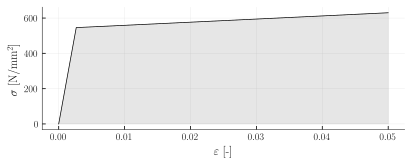

In [22]:
#| label: fig-sigma-eps-a3v2
#| fig-cap: "Spannungs-Dehnungs-Beziehung der Schubbewehrung, übernommen aus @gitz_ansatze_2024"


epsilon_w_A3V2 = np.array([0.0, 546 / 205000, 0.05])

plt.plot(to_float(epsilon_w_A3V2), to_float(sigma_w_A3V2) / 1000**2, color="black")
plt.fill_between(
    to_float(epsilon_w_A3V2), to_float(sigma_w_A3V2) / 1000**2, color="black", alpha=0.1
)
plt.xlabel("$\\varepsilon$ [-]")
plt.ylabel("$\\sigma$ [N/mm$^2$]")
plt.savefig("imgs/sigma_epsilon_A3V2.svg")

plt.show()

Die Tabelle @tbl-calcs-a3v2 zeigt die angewendeten Parameter zur Bestimmung der Wegfedercharakteristik in vertikaler Richtung. Der gewählte Neigungswinkel der Spannungsfelder $\theta_c3$ gilt grundsätzlich nur im Bruchzustand. Als Approximation wird die daraus bestimmte Wegfedercharakteristik für sämtliche Laststufen angesetzt. Dies führt zu Abweichungen im Lastniveau unterhalb der Traglast, sofern die Schubverformung einen signifikanten Einfluss an der der Gesamtverformung liefern.

In [23]:
#| label: tbl-calcs-a3v2
#| tbl-cap: "Berechungen zur Schubsteifigkeit des Dreipunktbiegeversuchs"


diam_sw_A3V2 = 6 * unit.mm
A_sw_A3V2 = 7 * (diam_sw_A3V2 / 2) ** 2 * np.pi
S_sw_A3V2 = 80 * unit.mm
a_sw_A3V2 = A_sw_A3V2 * 1000 * unit.mm / S_sw_A3V2 / unit.m
b_w_A3V2 = 800 * unit.mm
rho_sw_A3V2 = a_sw_A3V2 / b_w_A3V2
z_approx_A3V2 = 140 * unit.mm
E_sw_A3V2 = 205000 * unit.N / unit.mm**2
E_sh_A3V2 = (sigma_w_A3V2[-1] - sigma_w_A3V2[-2]) / (epsilon_w_A3V2[-1] - epsilon_w_A3V2[-2])
theta_sw_A3V2 = 34.3 * unit.degree
a3v2_schub = {
    "\oslash_sw":
    diam_sw_A3V2.evalf(3),
    "A_sw":
    A_sw_A3V2.evalf(3),
    "S_sw":
    S_sw_A3V2.evalf(3),
    "a_sw":
    a_sw_A3V2.evalf(3),
    "b_w":
    b_w_A3V2.evalf(3),
    "rho_sw":
    to_convert(rho_sw_A3V2.evalf(3).simplify(), unit.percent),
    "z_approx":
    z_approx_A3V2,
    "E_sw":
    E_sw_A3V2,
    "E_sh":
    E_sh_A3V2.evalf(4),
    "theta_c3":
    theta_sw_A3V2,
}

dict_to_table(a3v2_schub, 'Schubsteifigkeit A3V2')

|  Schubsteifigkeit A3V2  | ​  |
|---|---|
| $A_{sw} = 198.0 \text{mm}^{2}$ | $E_{sh} = \frac{1775.0 \text{N}}{\text{mm}^{2}}$ |
| $E_{sw} = \frac{205000 \text{N}}{\text{mm}^{2}}$ | $S_{sw} = 80.0 \text{mm}$ |
| $\oslash_{sw} = 6.0 \text{mm}$ | $a_{sw} = \frac{2.47 \cdot 10^{3} \text{mm}^{2}}{\text{m}}$ |
| $b_{w} = 800.0 \text{mm}$ | $\rho_{sw} = 0.309 \%$ |
| $\theta_{c3} = 34.3 ^\circ$ | $z_{approx} = 140 \text{mm}$ |


In [24]:
F_w_A3V2 = sigma_w_A3V2 * 3*A_sw_A3V2
# F_w_A3V2 = sigma_w_A3V2 * a_sw_A3V2 * z_approx_A3V2 * sp.cot(theta_sw_A3V2)

E_s_A3V2 = sigma_w_A3V2 / epsilon_w_A3V2

In [25]:
gamma_element_A3V2 = z_approx_A3V2 * sp.cot(theta_sw_A3V2) / l_element
u_sw_A3V2 = epsilon_w_A3V2 * z_approx_A3V2 / gamma_element_A3V2

display_eq('\gamma_{Element}', np.round(to_float(gamma_element_A3V2)))




\gamma_{Element} = 21.0

Die @fig-wegfeder-schub-a3v2 zeigt das Kraft-Verformungs-Verhalten für die Gelenke des Stabmodells in vertikaler Richtung.

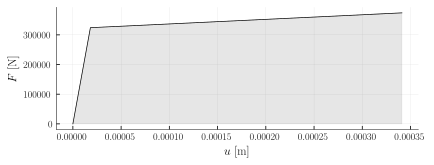

In [26]:
#| label: fig-wegfeder-schub-a3v2
#| fig-cap: "Berechnete Wegfedercharakteristik des Schubgelenks vom Versuch A3V2"


plt.plot(to_float(u_sw_A3V2), to_float(F_w_A3V2), color="black")
plt.fill_between(to_float(u_sw_A3V2), to_float(F_w_A3V2), color="black", alpha=0.1)
plt.xlabel("$u$ [m]")
plt.ylabel("$F$ [N]")
plt.show()

### Versuchsvergleich

Mit den bestimmten Federcharakteristiken kann die Biegelinie des Systems ermittelt werden unter Berücksichtigung der Schub- und Biegeverformungen auf nicht-linearen Grundlagen. Die @fig-fwa3v2 zeigt das Last-Verformungs-Diagramm des Systems am Punkt $w_1$. Das Modell beschreibt den Verformungsverlauf zufriedenstellend.

In [27]:
# Versuch Jaeger
w_1_versuch_A3V2 = np.array(
    [2.6, 10.2, 10.3, 11.5, 11.6, 13, 13.1, 14.9, 15.1, 23.8, 24.3, 35.4, 39.4, 40.1]
)
F_A_versuch_A3V2 = np.array(
    [
        0,
        211.3,
        204.1,
        241.9,
        236.8,
        271.3,
        260.3,
        300.6,
        287.7,
        324.6,
        293.5,
        331.2,
        325.1,
        301.8,
    ]
)


# Read the Excel file
modell_A3V2 = pd.read_excel('calcs\FEM\AxisVM\FEM_daten.xlsx', sheet_name='A3V2_Knotenfedern')
modell_A3V2_zugversteift = pd.read_excel('calcs\FEM\AxisVM\FEM_daten.xlsx', sheet_name='A3V2_Knotenfedern_zugversteift')

F_a3v2_model = 320

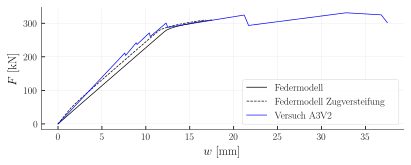

In [28]:
#| label: fig-fwa3v2
#| fig-cap: "Last-Verformungs-Verlauf am Punkt $w_1$ mit dem Federmodell und den Versuchsmessungen"


w_calc_a3v2 = modell_A3V2['eZ_1 [mm]']*-1
F_calc_a3v2 = modell_A3V2['Lpa']*F_a3v2_model

w_calc_a3v2_zugversteift = modell_A3V2_zugversteift['eZ_1 [mm]']*-1
F_calc_a3v2_zugversteift = modell_A3V2_zugversteift['Lpa']*F_a3v2_model


plt.plot(w_calc_a3v2, F_calc_a3v2, color="black", label="Federmodell")
plt.plot(w_calc_a3v2_zugversteift, F_calc_a3v2_zugversteift, color="black",linestyle='dashed', label="Federmodell Zugversteifung")

plt.plot(
    w_1_versuch_A3V2 - w_1_versuch_A3V2[0],
    F_A_versuch_A3V2,
    color="blue",
    label="Versuch A3V2",
)
plt.xlabel("$w$ [mm]")
plt.ylabel("$F$ [kN]")
plt.legend()
plt.savefig("imgs/F_w_nachrechnung_A3V2.svg")
plt.show()

In [29]:
DF_A3V2_LS320 = pd.read_excel("calcs\FEM\AxisVM\FEM_daten.xlsx", sheet_name='A3V2_Federmodell_maxlast')
x_array_A3V2 = np.linspace(0, 2620, len(DF_A3V2_LS320.iloc[:, 0]))

Der Verdrehungsverlauf in @fig-phi-max-a3v2 lässt sich ebenfalls direkt aus dem Modell exportieren. Durch die Ableitung des Verlaufs resultiert der Krümmungsverlauf, dargestellt in @fig-chi-max-a3v2.

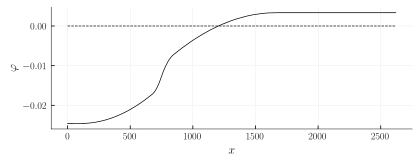

In [30]:
#| label: fig-phi-max-a3v2
#| fig-cap: "Verdrehungsverlauf aus dem Federmodell für die Höchstlast"


plt.plot(x_array_A3V2, DF_A3V2_LS320.iloc[:, -3], color="black")
plt.plot(x_array_A3V2, np.zeros(x_array_A3V2.shape), color="black", linestyle="dashed")

plt.xlabel("$x$")
plt.ylabel("$\\varphi$")
plt.show()

Der Krümmungsverlauf gibt Aufschluss über den Fliessbereich der Bewehrung, bzw. über den Steifigkeitenverlauf über die Stabachse.

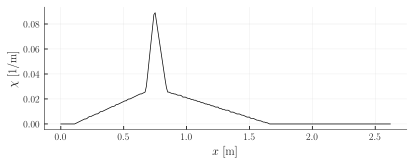

In [31]:
#| label: fig-chi-max-a3v2
#| fig-cap: "Berechneter Krümmungsverlauf aus dem Verdrehungsverlauf"


chi_a3v2 = np.gradient(DF_A3V2_LS320.iloc[:, -3], 0.01)

plt.plot(x_array_A3V2 / 1000, chi_a3v2, color="black")
plt.ylabel("$\\chi$ [1/m]")
plt.xlabel("$x$ [m]")
plt.savefig("imgs/kruemmungsverlauf_A3V2_axis.svg")
plt.show()

In [32]:
D = sp.symbols('D')

In [33]:
A_s_staender = 3*A_sw_A3V2

Diam_staender = sp.solve(sp.Eq(A_s_staender, sp.pi * D**2 /4), D)[1]
# display_eq('\oslash_staender',Diam_staender.evalf(3))

In [34]:
A_s_zuggurt = 2262*unit.mm**2

Diam_zuggurt = sp.solve(sp.Eq(A_s_zuggurt, sp.pi * D**2 /4), D)[1]
# display_eq('\oslash_zuggurt',Diam_zuggurt.evalf(3))

## Vierpunktbiegeversuch

Der Vierpunktbiegeversuch ist aus dem Paper @tue_einfluss_2019 entnommen.

![Bewehrungslayout des Versuchs SV14, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/versuchsskizze_14.svg){#fig-versuchsskizze-sv14}

Das statische System ist in der @fig-system-sv14 gezeigt.

![Statisches System des Versuchs SV14, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/statisches_system_14.svg){#fig-system-sv14}


### Drehfedercharakteristik

In [35]:
# Read the text file using numpy
M_SV14_array = np.loadtxt("docs/M_SV14.txt")
chi_SV14_array = np.loadtxt("docs/chi_SV14.txt")
chi_SV14_zugversteifung_1_array = chi_SV14_array.copy()
chi_SV14_zugversteifung_1_array[2] = chi_SV14_array[2]-0.000779
chi_SV14_zugversteifung_1_array[3] = chi_SV14_array[3]-0.000779
chi_SV14_zugversteifung_1_array[4] = chi_SV14_array[4]-0.000779


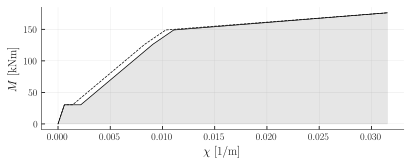

In [36]:
#| label: fig-mchi_sv14
#| fig-cap: "Momenten-Krümmungs-Beziehung des Vierpunktbiegeversuchs, übernommen aus @gitz_ansatze_2024"



chi_SV14_interpolated = np.linspace(0, max(chi_SV14_array), 1000)
# Linear interpolation in M_array
M_SV14_interpolated = np.interp(chi_SV14_interpolated, chi_SV14_array, M_SV14_array)

M_SV14_1_interpolated = np.interp(chi_SV14_interpolated, chi_SV14_zugversteifung_1_array, M_SV14_array)
# Plot the interpolated data



# Plot the interpolated data
plt.plot(chi_SV14_interpolated, M_SV14_interpolated / 10**3, color="black")
plt.plot(chi_SV14_interpolated, M_SV14_1_interpolated / 10**3, color="black", linestyle='dashed', label='Zugversteifung')


plt.fill_between(
    chi_SV14_interpolated, M_SV14_interpolated / 10**3, color="black", alpha=0.1
)
plt.xlabel("$\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.savefig("imgs/M_chi_SV14.svg")

plt.show()

### Wegfedercharakteristik

#### Schiebung


In [37]:
sigma_w_SV14 = np.array([0.0, 550, 657]) * unit.N / unit.mm**2

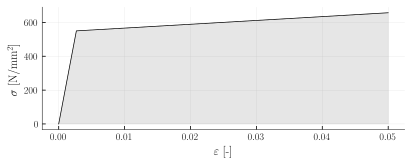

In [38]:
#| label: fig-sigma-epsilon-sv14
#| fig-cap: "Spannungs-Dehnungs-Beziehung der Schubbewehrung, übernommen aus @gitz_ansatze_2024"



epsilon_w_SV14 = np.array([0.0, 550 / 205000, 0.05])

plt.plot(to_float(epsilon_w_SV14), to_float(sigma_w_SV14) / 1000**2, color="black")
plt.fill_between(
    to_float(epsilon_w_SV14), to_float(sigma_w_SV14) / 1000**2, color="black", alpha=0.1
)
plt.xlabel("$\\varepsilon$ [-]")
plt.ylabel("$\\sigma$ [N/mm$^2$]")
plt.show()

In [39]:
#| label: tbl-calcs-sv14
#| tbl-cap: "Parameter zur Schubsteifigkeit des Vierpunktbiegeversuchs"


diam_sw_sv14 = 4.3 * unit.mm
A_sw = 2 * (diam_sw_sv14 / 2) ** 2 * np.pi
S_sw_sv14 = 300 * unit.mm
a_sw_sv14 = A_sw * 1000 * unit.mm / S_sw_sv14 / unit.m
b_w_sv14 = 170 * unit.mm
rho_sw_sv14 = a_sw_sv14 / b_w_sv14
z_approx_sv14 = 359 * unit.mm
E_sw_sv14 = 205000 * unit.N / unit.mm**2
E_sh_sv14 = (sigma_w_SV14[-1] - sigma_w_SV14[-2]) / (epsilon_w_SV14[-1] - epsilon_w_SV14[-2])
theta_sw_sv14 = 12.3 * unit.degree

sv14_schub = {
    "\oslash_sw":
    diam_sw_sv14.evalf(3),
    "A_sw":
    A_sw.evalf(3),
    "S_sw":
    S_sw_sv14.evalf(3),
    "a_sw":
    a_sw_sv14.evalf(3),
    "b_w":
    b_w_sv14.evalf(3),
    "rho_sw":
    to_convert(rho_sw_sv14.evalf(3).simplify(), unit.percent),
    "z_approx":
    z_approx_sv14,
    "E_sw":
    E_sw_sv14,
    "E_sh":
    E_sh_sv14.evalf(4),
    "theta_c3":
    theta_sw_sv14,
}

dict_to_table(sv14_schub, 'Schubsteifigkeit SV14')

|  Schubsteifigkeit SV14  | ​  |
|---|---|
| $A_{sw} = 29.0 \text{mm}^{2}$ | $E_{sh} = \frac{2261.0 \text{N}}{\text{mm}^{2}}$ |
| $E_{sw} = \frac{205000 \text{N}}{\text{mm}^{2}}$ | $S_{sw} = 300.0 \text{mm}$ |
| $\oslash_{sw} = 4.3 \text{mm}$ | $a_{sw} = \frac{96.8 \text{mm}^{2}}{\text{m}}$ |
| $b_{w} = 170.0 \text{mm}$ | $\rho_{sw} = 0.0569 \%$ |
| $\theta_{c3} = 12.3 ^\circ$ | $z_{approx} = 359 \text{mm}$ |


In [40]:
def epsilon_c(q, sigma_sy, as_w, theta, b_w, E_c, z):
    return (q + sigma_sy*as_w) / (np.sin(theta)**2 * b_w * E_c) * z * 1/np.tan(theta)


epsilon_c_SV14 = epsilon_c(0, to_float(sigma_w_SV14), to_float(a_sw_sv14), to_float(theta_sw_sv14), to_float(b_w_sv14), to_float(30000*unit.N/unit.mm**2), to_float(z_approx_sv14))


epsilon_SV14 = epsilon_w_SV14 + epsilon_c_SV14



##### Bewehrungseigenschaften

In [41]:
F_w_SV14 = sigma_w_SV14 * a_sw_sv14 * z_approx_sv14 * sp.cot(theta_sw_sv14)

E_s_SV14 = sigma_w_SV14 / epsilon_SV14

In [42]:
gamma_element = z_approx_sv14 * sp.cot(theta_sw_sv14) / l_element
u_sw_SV14 = epsilon_SV14 * z_approx_sv14 / gamma_element

display_eq('\gamma_{Element}', np.round(to_float(gamma_element)))




\gamma_{Element} = 165.0

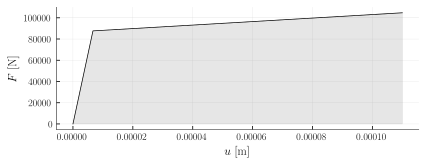

In [43]:
#| label: fig-wegfeder-schub-sv14
#| fig-cap: "Berechnete Wegfedercharakteristik des Schubgelenks vom Versuch SV14"


plt.plot(to_float(u_sw_SV14), to_float(F_w_SV14), color="black")
plt.fill_between(to_float(u_sw_SV14), to_float(F_w_SV14), color="black", alpha=0.1)
plt.xlabel("$u$ [m]")
plt.ylabel("$F$ [N]")
plt.show()

In [44]:
# Read the Excel file
modell_SV14 = pd.read_excel('calcs\FEM\AxisVM\FEM_daten.xlsx', sheet_name='SV14_Federmodell')
modell_SV14_zugversteift = pd.read_excel('calcs\FEM\AxisVM\FEM_daten.xlsx', sheet_name='SV14_Federmodell_zugversteift')

F_SV14_model = 110

In [45]:
# Versuch Tue


w_1_versuch_SV14 = np.array([
    0,
    0.28571428571428825,
    0.44642857142857295,
    0.5000000000000027,
    0.767857142857145,
    1.2500000000000018,
    3.3392857142857153,
    5.750000000000002,
    6.875000000000002,
    9.178571428571432,
    13.25,
    16.78571428571429,
    20.85714285714286,
    24.28571428571429,
    28.035714285714292,
    31.571428571428577,
    33.392857142857146,
    35.160714285714285,
    37.410714285714285,
]
)

F_A_versuch_SV14 = np.array([
    0,
    5.315436241610726,
    7.087248322147644,
    8.859060402684563,
    11.516778523489918,
    14.322147651006702,
    20.375838926174495,
    28.791946308724818,
    33.221476510067106,
    41.63758389261744,
    57.583892617449656,
    69.54362416107382,
    78.40268456375838,
    84.60402684563758,
    92.57718120805369,
    99.51677852348993,
    102.02684563758389,
    103.6510067114094,
    104.53691275167785,
])



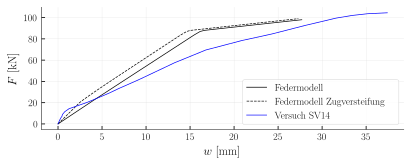

In [46]:
#| label: fig-l-w-sv14
#| fig-cap: "Last-Verformungs-Verlauf am Punkt $w_1$, für das Federmodell und den Versuch"



w_calc_SV14 = modell_SV14['eZ_1 [mm]']*-1
F_calc_SV14 = modell_SV14['Lpa']*F_SV14_model

w_calc_SV14_zugversteift = modell_SV14_zugversteift['eZ_1 [mm]']*-1
F_calc_SV14_zugversteift = modell_SV14_zugversteift['Lpa']*F_SV14_model


plt.plot(w_calc_SV14, F_calc_SV14, color="black", label="Federmodell")
plt.plot(w_calc_SV14_zugversteift, F_calc_SV14_zugversteift, color="black",linestyle='dashed', label="Federmodell Zugversteifung")

plt.plot(
    w_1_versuch_SV14 - w_1_versuch_SV14[0],
    F_A_versuch_SV14,
    color="blue",
    label="Versuch SV14",
)



plt.xlabel("$w$ [mm]")
plt.ylabel("$F$ [kN]")
plt.legend()
plt.savefig("imgs/F_w_nachrechnung_SV14.svg")
plt.show()